# Time Complexity Notebook
This notebook calculates how long our simulation takes to run as we vary the parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import glob
import pandas as pd
import time

import os

In [2]:
def reflect(val, wall_val):
    return 2*wall_val - val

class Obstacle:
    #convention: walls only have a right side
    left_wall = None
    right_wall = None
    top_wall = None
    bottom_wall = None
    obstacle_type = None

    def __init__(self, lw, rw, tw, bw, obstacle_type):
        self.left_wall = lw
        self.right_wall = rw
        self.top_wall = tw
        self.bottom_wall = bw
        assert (obstacle_type == "wall" or
                obstacle_type == "corner" or
                obstacle_type == "box"), "bad obstacle type"
        self.obstacle_type = obstacle_type
        return None

    def is_outside(self, point):
        x = point[0]
        y = point[1]
        if self.obstacle_type == "wall":
            is_ok_x = (x > self.right_wall)
            return is_ok_x
        elif self.obstacle_type == "corner":
            is_bad_x = (x < self.right_wall)
            is_bad_y = (y < self.top_wall)
            return not (is_bad_x and is_bad_y)
        elif self.obstacle_type == "box":
            is_ok_x = (x < self.right_wall and x > self.left_wall)
            is_ok_y = (y < self.top_wall and y > self.bottom_wall)
            return (is_ok_x and is_ok_y)
        else:
            print("obstacle type not implemented yet")
        return None

    def is_outside2(self, point):
        # true means the move is allowed
        x = point[0]
        y = point[1]
        bounce_x = False
        bounce_y = False
        legal_move = True
        if self.obstacle_type == "wall":
            is_ok_x = (x > self.right_wall)
            legal_move = is_ok_x
            bounce_x = not is_ok_x
        elif self.obstacle_type == "corner":
            is_bad_x = (x < self.right_wall)
            is_bad_y = (y < self.top_wall)
            legal_move = not (is_bad_x and is_bad_y)
            bounce_x = is_bad_x
            bounce_y = is_bad_y
        elif self.obstacle_type == "box":
            is_ok_x = (x < self.right_wall and x > self.left_wall)
            is_ok_y = (y < self.top_wall and y > self.bottom_wall)
            legal_move = (is_ok_x and is_ok_y)
            bounce_x = not is_ok_x
            bounce_y = not is_ok_y
        else:
            print("obstacle type not implemented yet")
        return [legal_move, bounce_x, bounce_y]

    def bounce_box(self, new_position, bounce_x, bounce_y):
        final_position = new_position
        if bounce_x:
            if new_position[0] < self.left_wall:
                # bouncing off left wall
                reflected_x = reflect(final_position[0], self.left_wall)
            else:
                #bouncing off right wall
                reflected_x = reflect(final_position[0], self.right_wall)
            final_position[0] = reflected_x
        if bounce_y:
            if new_position[1] < self.bottom_wall:
                # bouncing off bottom wall
                reflected_y = reflect(final_position[1], self.bottom_wall)
            else:
                #bouncing off top wall
                reflected_y = reflect(final_position[1], self.top_wall)
            final_position[1] = reflected_y
        return final_position

class Diffusive_particle:
    def __init__(self, x0, y0, z0, rng=0):
        self.x = x0
        self.y = y0
        self.z = y0
        self.xhistory = np.array([x0])
        self.yhistory = np.array([y0])
        self.zhistory = np.array([z0])
        return None

    def time_evolve(self, N, obstacle=None):
        rng = np.random.default_rng()
        phi_values = rng.random(N) * np.pi
        theta_values = rng.random(N) * 2 * np.pi
        for i in range(len(phi_values)):
            xmove = np.cos(theta_values[i])*np.sin(phi_values[i])
            ymove = np.sin(theta_values[i])*np.sin(phi_values[i])
            new_location = [self.x + xmove, self.y + ymove]
            if obstacle==None or obstacle.is_outside(new_location):
#                 self.x += xmove
#                 self.y += ymove
                self.x = new_location[0]
                self.y = new_location[1]
            self.xhistory = np.append(self.xhistory, self.x)
            self.yhistory = np.append(self.yhistory, self.y)
            self.zhistory = np.append(self.zhistory, self.z)
        return None

    def time_evolve2(self, N, obstacle=None):
        rng = np.random.default_rng()
        phi_values = rng.random(N) * np.pi
        theta_values = rng.random(N) * 2 * np.pi

        for i in range(len(phi_values)):
            xmove = np.cos(theta_values[i])*np.sin(phi_values[i])
            ymove = np.sin(theta_values[i])*np.sin(phi_values[i])
            new_location = [self.x + xmove, self.y + ymove]
            bounce_data = obstacle.is_outside2(new_location)
            bounced_location = obstacle.bounce_box(new_location, bounce_data[1], bounce_data[2])
            self.x = bounced_location[0]
            self.y = bounced_location[1]
            self.xhistory = np.append(self.xhistory, self.x)
            self.yhistory = np.append(self.yhistory, self.y)
            self.zhistory = np.append(self.zhistory, self.z)
        return None

class Particle_collection:
    def __init__(self):
        self.particles = []

    def add_particle(self, particle):
        self.particles.append(particle)

def generate_batch(batchsize, steps, savename, obstacle=None):
    f = open(savename, "wb")
    collection = Particle_collection()
    rng = np.random.default_rng()
    for i in range(batchsize):
        newPoint = Diffusive_particle(0,0,0, rng)
        newPoint.time_evolve(steps, obstacle)
        collection.add_particle(newPoint)
    pickle.dump(collection, f)
    f.close()

def generate_batch_bouncebox(batchsize, steps, savename, obstacle=None):
    # only used with box
    f = open(savename, "wb")
    collection = Particle_collection()
    rng = np.random.default_rng()
    for i in range(batchsize):
        newPoint = Diffusive_particle(0,0,0, rng)
        newPoint.time_evolve2(steps, obstacle)
        collection.add_particle(newPoint)
    pickle.dump(collection, f)
    f.close()

def load_data_into_N_collections(saveDir, N):
    collection_arr = []
    filenames = np.sort(glob.glob(saveDir + "*"))
    file_count = np.size(filenames)
    lump_size = file_count // N

    start = 0
    end = lump_size
    for i in range(N):
        print(f"start: {start} and end{end}")
        loop_collection = Particle_collection()
        loop_filenames = filenames[start:end]
        for filename in loop_filenames:
            f = open(filename, "rb")
            temp_collection = pickle.load(f)
            for particle in temp_collection.particles:
                loop_collection.particles.append(particle)
            f.close()
        collection_arr.append(loop_collection)
        start += lump_size
        end += lump_size
    return collection_arr

# generate_basic_diffusion_plot

def plot_particle_collection(ax, collection, time, kwargs):
    xvals = []
    yvals = []

    for particle in collection.particles:
        xvals.append(particle.xhistory[time])
        yvals.append(particle.yhistory[time])

    ax.plot(xvals, yvals, **kwargs)
    return None

def generate_diffusion_plot(collection_arr, times, border_val, kwargs):
    fig, ax = plt.subplots(2,2, sharex=True, sharey=True)
    axes = [(0,0), (0,1), (1,0), (1,1)] # the four axes of the plot
    for big_collection in collection_arr:
        for i in range(4):
            plot_particle_collection(ax[axes[i]], big_collection, times[i], kwargs)
            ax[axes[i]].set_aspect("equal") # make the images square

    if (type(border_val) is list):
        ax[0,0].set_xlim([border_val[0], border_val[1]])
        ax[0,0].set_ylim([border_val[2], border_val[3]])
    else:
        ax[0,0].set_xlim([-1*border_val, border_val])
        ax[0,0].set_ylim([-1*border_val, border_val])

    for i in range(4):
        ax[axes[i]].set_title(f"steps={times[i]}")

    fig.tight_layout()
    fig.show()
    return None

def gen_particle_hist_with_errors(collection_arr, left, right, time):
    num_batches = np.size(collection_arr)
    edges = np.arange(left, right+1)- 0.5
    plotting_centers = edges[:-1] + 0.5
    bincount_arr = np.zeros((num_batches, np.size(edges)-1))
    for i in range(num_batches):
        xvals = []
        yvals = []
        for particle in collection_arr[i].particles:
            xvals.append(particle.xhistory[time])
        bincount, _ = np.histogram(xvals, bins=edges, density=True)

        bincount_arr[i, :] = bincount


    # calculate statistics
    bincount_means = np.mean(bincount_arr, axis=0)
    standard_error_of_mean = np.std(bincount_arr, axis=0) / np.sqrt(num_batches)


    return plotting_centers, bincount_means, standard_error_of_mean

def plot_particle_hist_with_errors(collection_arr, left, right, times):
    fig, ax = plt.subplots(1,1)

    for i in range(len(times)):
        kwargs = {
            "marker": ".",
            "ms": 0.5,
            "linewidth": 0.5,
            "label": "t={:d}".format(times[i]),
        }
        plt_cen, binc, stderr = gen_particle_hist_with_errors(collection_arr, left, right, times[i])
        ax.errorbar(plt_cen, binc, yerr = stderr, **kwargs)


    ax.legend()
    fig.show()

In [3]:
# # experimental functions
# def generate_2d_plot(collection_arr, times, border_val, kwargs):
#     fig, ax = plt.subplots(2,2, sharex=True, sharey=True)
#     axes = [(0,0), (0,1), (1,0), (1,1)] # the four axes of the plot

#     time=times[2]

#     num_batches = np.size(collection_arr)
#     xvals = []
#     yvals = []
#     for i in range(num_batches):
#         for particle in collection_arr[i].particles:
#             xvals.append(particle.xhistory[time])
#             yvals.append(particle.yhistory[time])

#     ax[0,0].hist2d(xvals, yvals)

# #     if (type(border_val) is list):
# #         ax[0,0].set_xlim([border_val[0], border_val[1]])
# #         ax[0,0].set_ylim([border_val[2], border_val[3]])
# #     else:
# #         ax[0,0].set_xlim([-1*border_val, border_val])
# #         ax[0,0].set_ylim([-1*border_val, border_val])

# #     for i in range(4):
# #         ax[axes[i]].set_title(f"steps={times[i]}")

# #     fig.tight_layout()
#     fig.show()
#     return None


def gen_particle_hist_with_errors_2d(collection_arr, left, right, time):
    num_batches = np.size(collection_arr)
    edges = np.arange(left, right+1)- 0.5
    plotting_centers = edges[:-1] + 0.5
    bincount_arr = np.zeros((num_batches, np.size(edges)-1, np.size(edges)-1))
#     bincount_arr_y = np.zeros((num_batches, np.size(edges)-1))

    for i in range(num_batches):
        xvals = []
        yvals = []
        for particle in collection_arr[i].particles:
            xvals.append(particle.xhistory[time])
            yvals.append(particle.yhistory[time])
#         print(np.shape(xvals))
        xvals = np.array(xvals)
        yvals = np.array(yvals)
#         print(np.shape(xvals))
#         bincounts, _, _, _ = plt.hist2d(xvals, yvals, bins=edges)
        bincounts, _, _ = np.histogram2d(xvals, yvals, bins=edges, density=True)

        bincount_arr[i, :, :] = bincounts

    # calculate statistics
    bincount_means = np.mean(bincount_arr, axis=0)

    return edges, bincount_means

def plot_particle_hist_with_errors_2d(collection_arr, left, right, times):
    fig, ax = plt.subplots(2,2)
    axes = [(0,0), (0,1), (1,0), (1,1)]


    for i in range(len(times)):
        kwargs = {
            "marker": ".",
            "ms": 0.5,
            "linewidth": 0.5,
            "label": "t={:d}".format(times[i]),
        }
        edges, bc_means = gen_particle_hist_with_errors_2d(collection_arr, left, right, times[i])
        img = ax[axes[i]].imshow(bc_means, origin="lower", extent=(left, right, left, right), vmax=0.05, cmap='jet')
#         img = ax[axes[i]].imshow(bc_means, origin="lower", extent=(left, right, left, right), norm='symlog', vmax=0.2, cmap='jet')
        plt.colorbar(img, ax=ax[axes[i]])


#         print(bc_x)

    for i in range(4):
            ax[axes[i]].set_title(f"steps={times[i]}")
    fig.tight_layout()
    fig.show()
    return None

In [4]:
def calc_std_at_time(collection_arr, time):
    num_batches = np.size(collection_arr)
    xvals = []
    for i in range(num_batches):
        for particle in collection_arr[i].particles:
            xvals.append(particle.xhistory[time])
    return np.std(xvals)

def generate_std_graph(collection_arr, times, kwargs):
    fig, ax = plt.subplots(1,1)
    std_arr = []
    for time in times:
        std_arr.append(calc_std_at_time(collection_arr, time))

    ax.plot(times,std_arr, **kwargs)
    fig.tight_layout()
    fig.show()
    return None

## Test Time Complexity
This notebook will check how the time it takes to simulate a sample changes with the number of particles and with the number of time-steps simulated. In order to do so, I will use a function to simulate writing one file while varying the particle number and holding time-steps constant, and also simulate writing one file while holding particle number constant and varying time-steps simulated.

In [11]:
test_save_filename = "./time-complexity-test-file"
def simulate_writing_one_file_time(num_particles, num_time_steps, savename):
    start_time = time.time()
    generate_batch(num_particles, num_time_steps, savename, None)
    end_time = time.time()
    return end_time - start_time

def simulate_varying_particles(max_particles, base_num_time_steps, savename):
    time_array = []
    particle_counts = (np.arange(max_particles//5) + 1) * 5
    for count in tqdm(particle_counts):
        time_array.append(simulate_writing_one_file_time(count, base_num_time_steps, savename))
    return particle_counts, np.array(time_array)

def simulate_varying_timesteps(max_timesteps, base_num_particles, savename):
    time_array = []
    timestep_counts = (np.arange(max_timesteps//5) + 1) * 5
    for count in tqdm(timestep_counts):
        time_array.append(simulate_writing_one_file_time(base_num_particles, count, savename))
    return timestep_counts, np.array(time_array)

base_num_particles = 10
base_num_time_steps = 10

max_particles = 1000
max_timesteps = 1000
particle_xvals, particle_vary_array = simulate_varying_particles(max_particles, base_num_time_steps, test_save_filename)
timestep_xvals, particle_vary_timesteps = simulate_varying_timesteps(max_timesteps, base_num_particles, test_save_filename)

# simulate_writing_one_file_time(100, 100, test_save_filename)

100%|██████████| 200/200 [00:26<00:00,  7.63it/s]


In [12]:
# try varying both
def simulate_varying_both(max_count, savename):
    time_array = []
    counts = (np.arange(max_count // 20) + 1) * 20
    for count in tqdm(counts):
        time_array.append(simulate_writing_one_file_time(count, count, savename))
    return counts, np.array(time_array)

max_both = 300
both_xvals, particle_vary_both = simulate_varying_both(max_both, test_save_filename)

100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


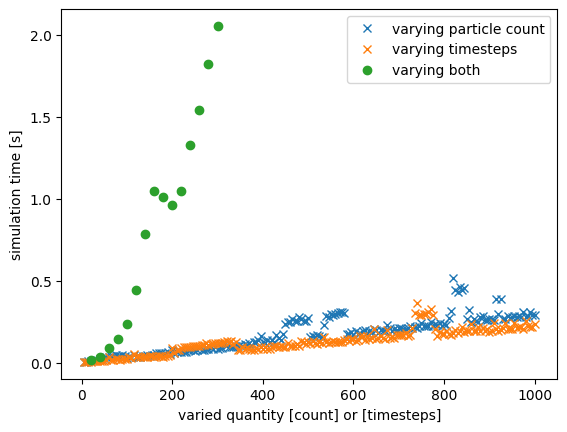

In [13]:
# generate the plot
fig, ax = plt.subplots(1,1)


# ax[0].plot(particle_counts, particle_vary_array)
# ax[1].plot(timestep_counts, particle_vary_timesteps)

kwargs = {
    "marker": "x",
    "ls": "none"
}

ax.plot(particle_xvals, particle_vary_array, label="varying particle count", **kwargs)
ax.plot(timestep_xvals, particle_vary_timesteps, label="varying timesteps", **kwargs)
ax.plot(both_xvals, particle_vary_both, label="varying both", marker="o", ls="none")

ax.set_ylabel("simulation time [s]")
ax.set_xlabel("varied quantity [count] or [timesteps]")
ax.legend()
fig.show()
